# How to Improve Fantasy Premier League

## Nikhil Isukapalli

### 20 March 2023

<p>&nbsp;</p>

# Introduction

Fantasy Premier League is a fantasy soccer game in which participants assemble a team of real life English Premier League footballers and score points based on those players' actual statistical performances on the pitch. At the beginning of each league season, users are given a budget of \\$100.0 million and tasked with selecting 15 players, with restrictions on playing position and club; players are initially priced between \\$4.0 million and \\$13.0 million and may increase or deecrease in value based on actual performance and in-game popularity as the season progresses.

As an avid soccer fan who has been playing FPL for almost six seasons, I have noticed that defensive midfielders are extremely underused in comparison with more attack-minded midfielders. For instance, N'Golo Kanté and Declan Rice ended the 2021-22 season featuring in just 2.4% and 4.3% of FPL teams, respectively. On the other hand, Kevin De Bruyne was owned by 18.6% of teams, and James Maddison was owned by 16.3% of teams at the conclusion of Gameweek 38. Kanté and Rice's ownership further pale in comparison to wingers such as Mohamed Salah (41.0%) and Bukayo Saka (28.8%), who are also classified as FPL midfielders.

<p>&nbsp;</p>

The current scoring rules for FPL involving midfielders are as follows:
* 1 point: for playing under 60 minutes
* 2 points: for playing at least 60 minutes (excluding stoppage time)
* 5 points: for each goal scored by a midfielder
* 3 points: for each assist
* 1 point: for a clean sheet by a midfielder
* 5 points: for each penalty save
* -2 points: for each penalty miss
* 1-3 points: bonus points for the best players in a match
* -1 point: for each yellow card
* -3 points: for each red card
* -2 points: for each own goal

<p>&nbsp;</p>

I seek to determine whether or not the FPL scoring system is inherently biased toward more attack-minded midfielders. If so, I intend to propose possible solutions to make defensive midfielders more valuable fantasy picks.

The data I am examining is aggregated in a GitHub database of FPL data and a collection of FBref match reports for all 380 games from the 2021-22 Premier League season. The GitHub database contains data such as in-game price, various in-game and actual statistics, and the proportion of users who have selected each player. It also contains detailed statistics for each player and gameweek. The match reports on FBref.com include team and individual player statistics for each game.

<p>&nbsp;</p>

Sources:\
https://fbref.com/en/comps/9/2021-2022/schedule/2021-2022-Premier-League-Scores-and-Fixtures\
https://github.com/vaastav/Fantasy-Premier-League/tree/master/data/2021-22

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('2021-22_FPL_Midfielders.csv')
data.head()

,Player,Minutes,Starting Price,Final Teams Selected By %,Interceptions,Tackles Won,Ball Recovery Points,Original Points
0,Aaron Lennon,1541,5.0,0.1,15,18,6,60
1,Abdoulaye Doucouré,2536,5.5,1.2,41,45,19,90
2,Adam Forshaw,1526,4.5,0.1,30,28,13,38
3,Adam Lallana,1559,5.5,0.1,27,22,10,44
4,Adama Traoré,1069,6.0,1.0,4,9,0,44


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Player                     237 non-null    object 
 1   Minutes                    237 non-null    int64  
 2   Starting Price             237 non-null    float64
 3   Final Teams Selected By %  237 non-null    float64
 4   Interceptions              237 non-null    int64  
 5   Tackles Won                237 non-null    int64  
 6   Ball Recovery Points       237 non-null    int64  
 7   Original Points            237 non-null    int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 14.9+ KB


<p>&nbsp;</p>

# Methods

I built a web scraper using *requests* and *BeautifulSoup* in Python to extract the data from the GitHub database and all 380 FBref match reports, and subsequently collect various parameters of interest in a CSV file. The code for the web scraper can be viewed in *scraper.py*, and the relevant data is aggregated in *2021-22_FPL_Midfielders.csv* (both files are included in this repository). The CSV contains 237 data points, with no null or missing values.

In my scraping program, I extracted general FPL data for minutes played, starting price, percent of teams that owned the player at the end of the season, and original FPL points total. As for actual in-game stats, I collected data on interceptions and tackles won, since defensive midfielders tend not to register many goals or assists. As the name suggests, a defensive midfielder's primary focus is to shield the defense and provide a link between the defense and the midfield; they greatly impact games by regaining possession for their team. Ball recoveries, in the form of interceptions and tackles won, are an excellent metric to assess defensive midfielder performance. To see if ball recoveries can be incorporated in the FPL scoring system, I established a rule that all midfielders earn 1 point for every 3 interceptions and successful tackles made. While scraping, I kept track of each player's ball recovery stats per game, and calculated the number of points they would earn from ball recoveries for each game. The 'Ball Recovery Points' column consists of each midfielder's total points gain from ball recoveries over all 38 games.

<p>&nbsp;</p>

For instance, if a player appeared in two matches during the season, the points he gains from ball recoveries are calculated as follows:
* Game 1: 4 successful tackles and interceptions. The player thus scores 1 ball recovery point.
* Game 2: 8 successful tackles and interceptions. The player thus scores 2 ball recovery points.
* Games 3-38: The player did not register any minutes, thus scoring 0 ball recovery points.
* Total: 3 ball recovery points. Note that fractional points cannot be awarded, so despite making 12 total ball recoveries, the player only scores 3 ball recovery points.

<p>&nbsp;</p>

The data is all numeric, except for the player name column. I cleaned the data while I was scraping in order to account for inconsistencies in player names across the FBref match reports and the GitHub database. For instance, GitHub would have a player's full name (ex: Rodrigo Hernández), while FBref would refer to them by a mononym or nickname (ex: Rodri). For other such players, I decided to use their name as recorded on FBref, since it is more publically recognizable.

I considered midfielders with under 500 minutes played to be outliers, since their performances over the season form too small a sample size to accurately compare them with other midfielders. Such players generally have either only started several games (but were otherwise unavailable or among the substitutes), or featured in many games mainly as a substitute. Thus, it is easy for them to have greatly inflated or deflated stats, so it makes sense to drop these rows from the dataframe.

<p>&nbsp;</p>

The first feature I added was 'Total Points per 90 Minutes.' I felt this was useful because the 'Minutes' feature has a large distribution; a player may have recorded fewer minutes as a result of injury, being rotated into the lineup or dropped due to poor form, or from arriving to the Premier League during the winter transfer window. Averaging their points total over every 90 minutes played (the standard length of a match) allows us to more accurately evaluate their performance against players who registered more minutes.

The second feature I added was 'Total Points per $1 Million.' As shown in the scatterplot of original FPL points vs. starting price, budget options generally score less than mid-priced and premium options. The plot suggests a roughly linear relationship between the two features, so total points per million in price seems like an accurate performance indicator. However, I chose to average the total points (after accounting for ball recovery points) instead of original FPL points since that is the parameter I am interested in measuring. In addition, due to the budget constraint, it is very difficult to have all five midfielders in your fantasy team be mid-priced or premium options. Thus, it is logical to consider more budget-friendly midfielders.

The third feature I added was 'Total Points per 90 per Million.' This combines the two aforementioned features I added to more accurately determine a player's value for money. A premium player such as Mohamed Salah may have an inflated total points per 90 minutes score. Conversely, a player who didn't feature for a portion of the season, like Emile Smith Rowe, may have a lower total points per $1 million score. The total points per 90 per million metric accounts for both cases.

In [4]:
data.drop(data.loc[data['Minutes'] < 500].index, inplace=True)
data['Total Points'] = data['Ball Recovery Points'] + data['Original Points']
data['Total Points per 90 Minutes'] = (data['Total Points'] * 90 / data['Minutes']).round(3)
data['Total Points per $1 Million'] = (data['Total Points'] / data['Starting Price']).round(3)
data['Total Points per 90 per Million'] = (data['Total Points per 90 Minutes'] / data['Starting Price']).round(3)
data.head()

,Player,Minutes,Starting Price,Final Teams Selected By %,Interceptions,Tackles Won,Ball Recovery Points,Original Points,Total Points,Total Points per 90 Minutes,Total Points per $1 Million,Total Points per 90 per Million
0,Aaron Lennon,1541,5.0,0.1,15,18,6,60,66,3.855,13.200,0.771
1,Abdoulaye Doucouré,2536,5.5,1.2,41,45,19,90,109,3.868,19.818,0.703
2,Adam Forshaw,1526,4.5,0.1,30,28,13,38,51,3.008,11.333,0.668
3,Adam Lallana,1559,5.5,0.1,27,22,10,44,54,3.117,9.818,0.567
4,Adama Traoré,1069,6.0,1.0,4,9,0,44,44,3.704,7.333,0.617


In [5]:
data.sort_values('Starting Price', ascending=False).head()

,Player,Minutes,Starting Price,Final Teams Selected By %,Interceptions,Tackles Won,Ball Recovery Points,Original Points,Total Points,Total Points per 90 Minutes,Total Points per $1 Million,Total Points per 90 per Million
157,Mohamed Salah,2758,12.5,41.0,15,7,1,265,266,8.680,21.280,0.694
26,Bruno Fernandes,3110,12.0,13.5,38,45,16,151,167,4.833,13.917,0.403
124,Kevin De Bruyne,2196,12.0,18.6,14,14,2,196,198,8.115,16.500,0.676
194,Sadio Mané,2818,12.0,4.8,15,18,4,183,187,5.972,15.583,0.498
184,Raheem Sterling,2121,11.0,2.6,15,18,3,163,166,7.044,15.091,0.640


In [6]:
data.sort_values('Interceptions', ascending=False).head()

,Player,Minutes,Starting Price,Final Teams Selected By %,Interceptions,Tackles Won,Ball Recovery Points,Original Points,Total Points,Total Points per 90 Minutes,Total Points per $1 Million,Total Points per 90 per Million
48,Declan Rice,3178,5.0,4.3,95,53,37,95,132,3.738,26.400,0.748
36,Christian Nørgaard,3054,5.0,0.6,85,80,45,101,146,4.303,29.200,0.861
114,Josh Brownhill,2952,4.5,3.6,79,41,28,92,120,3.659,26.667,0.813
210,Stuart Dallas,2920,5.5,2.7,78,47,31,80,111,3.421,20.182,0.622
181,Pierre-Emile Højbjerg,3196,5.0,2.6,70,49,30,109,139,3.914,27.800,0.783


In [7]:
data.sort_values('Tackles Won', ascending=False).head()

,Player,Minutes,Starting Price,Final Teams Selected By %,Interceptions,Tackles Won,Ball Recovery Points,Original Points,Total Points,Total Points per 90 Minutes,Total Points per $1 Million,Total Points per 90 per Million
36,Christian Nørgaard,3054,5.0,0.6,85,80,45,101,146,4.303,29.200,0.861
109,John McGinn,3090,6.0,1.1,52,61,27,110,137,3.990,22.833,0.665
13,Allan,2181,4.5,2.9,42,61,22,58,80,3.301,17.778,0.734
173,Oriol Romeu,2890,4.5,0.5,67,54,30,88,118,3.675,26.222,0.817
106,João Moutinho,2970,5.0,0.7,48,54,20,96,116,3.515,23.200,0.703


In [8]:
data.sort_values('Ball Recovery Points', ascending=False).head()

,Player,Minutes,Starting Price,Final Teams Selected By %,Interceptions,Tackles Won,Ball Recovery Points,Original Points,Total Points,Total Points per 90 Minutes,Total Points per $1 Million,Total Points per 90 per Million
36,Christian Nørgaard,3054,5.0,0.6,85,80,45,101,146,4.303,29.200,0.861
48,Declan Rice,3178,5.0,4.3,95,53,37,95,132,3.738,26.400,0.748
210,Stuart Dallas,2920,5.5,2.7,78,47,31,80,111,3.421,20.182,0.622
173,Oriol Romeu,2890,4.5,0.5,67,54,30,88,118,3.675,26.222,0.817
181,Pierre-Emile Højbjerg,3196,5.0,2.6,70,49,30,109,139,3.914,27.800,0.783


In [9]:
data.sort_values('Original Points', ascending=False).head()

,Player,Minutes,Starting Price,Final Teams Selected By %,Interceptions,Tackles Won,Ball Recovery Points,Original Points,Total Points,Total Points per 90 Minutes,Total Points per $1 Million,Total Points per 90 per Million
157,Mohamed Salah,2758,12.5,41.0,15,7,1,265,266,8.680,21.280,0.694
205,Son Heung-min,3009,10.0,35.6,29,12,5,258,263,7.866,26.300,0.787
99,Jarrod Bowen,2987,6.5,15.0,38,26,10,206,216,6.508,33.231,1.001
124,Kevin De Bruyne,2196,12.0,18.6,14,14,2,196,198,8.115,16.500,0.676
194,Sadio Mané,2818,12.0,4.8,15,18,4,183,187,5.972,15.583,0.498


In [10]:
data.sort_values('Total Points', ascending=False).head()

,Player,Minutes,Starting Price,Final Teams Selected By %,Interceptions,Tackles Won,Ball Recovery Points,Original Points,Total Points,Total Points per 90 Minutes,Total Points per $1 Million,Total Points per 90 per Million
157,Mohamed Salah,2758,12.5,41.0,15,7,1,265,266,8.680,21.280,0.694
205,Son Heung-min,3009,10.0,35.6,29,12,5,258,263,7.866,26.300,0.787
99,Jarrod Bowen,2987,6.5,15.0,38,26,10,206,216,6.508,33.231,1.001
124,Kevin De Bruyne,2196,12.0,18.6,14,14,2,196,198,8.115,16.500,0.676
194,Sadio Mané,2818,12.0,4.8,15,18,4,183,187,5.972,15.583,0.498


In [11]:
data.sort_values('Total Points per 90 Minutes', ascending=False).head()

,Player,Minutes,Starting Price,Final Teams Selected By %,Interceptions,Tackles Won,Ball Recovery Points,Original Points,Total Points,Total Points per 90 Minutes,Total Points per $1 Million,Total Points per 90 per Million
208,Steven Bergwijn,548,6.0,0.4,4,4,0,55,55,9.033,9.167,1.505
157,Mohamed Salah,2758,12.5,41.0,15,7,1,265,266,8.680,21.280,0.694
187,Riyad Mahrez,1485,9.0,4.0,13,6,1,135,136,8.242,15.111,0.916
124,Kevin De Bruyne,2196,12.0,18.6,14,14,2,196,198,8.115,16.500,0.676
205,Son Heung-min,3009,10.0,35.6,29,12,5,258,263,7.866,26.300,0.787


In [12]:
data.sort_values('Total Points per $1 Million', ascending=False).head()

,Player,Minutes,Starting Price,Final Teams Selected By %,Interceptions,Tackles Won,Ball Recovery Points,Original Points,Total Points,Total Points per 90 Minutes,Total Points per $1 Million,Total Points per 90 per Million
99,Jarrod Bowen,2987,6.5,15.0,38,26,10,206,216,6.508,33.231,1.001
36,Christian Nørgaard,3054,5.0,0.6,85,80,45,101,146,4.303,29.200,0.861
40,Conor Gallagher,2843,5.5,11.2,43,44,17,140,157,4.970,28.545,0.904
30,Bukayo Saka,2978,6.5,28.8,31,23,6,179,185,5.591,28.462,0.860
181,Pierre-Emile Højbjerg,3196,5.0,2.6,70,49,30,109,139,3.914,27.800,0.783


In [13]:
data.sort_values('Total Points per 90 per Million', ascending=False).head()

,Player,Minutes,Starting Price,Final Teams Selected By %,Interceptions,Tackles Won,Ball Recovery Points,Original Points,Total Points,Total Points per 90 Minutes,Total Points per $1 Million,Total Points per 90 per Million
208,Steven Bergwijn,548,6.0,0.4,4,4,0,55,55,9.033,9.167,1.505
27,Bruno Guimarães,1031,5.0,2.8,19,39,13,67,80,6.984,16.000,1.397
49,Dejan Kulusevski,1259,6.0,10.9,26,16,9,99,108,7.720,18.000,1.287
164,Naby Keïta,1169,5.0,0.2,20,28,11,65,76,5.851,15.200,1.170
59,Emile Smith Rowe,1909,5.5,10.0,20,16,4,125,129,6.082,23.455,1.106


<p>&nbsp;</p>

# Results

In the scatterplots below, I highlighted 15 FPL midfielders (5 defensive midfielders, 5 attacking midfielders, and 5 wingers) who were all important players for their clubs during the 2021-22 season. The defensive midfielders are all priced at either \\$5.0 or \\$5.5 million. For the attacking midfielders and wingers, I chose players in a wide price range, from Emile Smith Rowe (\\$5.5 million) to Mohamed Salah (\\$12.5 million). These 15 midfielders are labeled as follows:

* Red: defensive midfielders (N'Golo Kanté, Declan Rice, Rodri, Christian Nørgaard, and Rúben Neves)
* Blue: attacking midfielders (Kevin De Bruyne, James Maddison, Emile Smith Rowe, Mason Mount, and Bruno Fernandes)
* Black: wingers (Mohamed Salah, Bukayo Saka, Son Heung-min, Raphinha, and Jarrod Bowen)

<p>&nbsp;</p>

In both the final teams selected by % vs. starting price, and the original points vs. starting price plots, the defensive midfielders are concentrated in the lower left corner. This suggests a causal relationship between ownership and pricing – because so few teams include defensive midfielders, FPL continues to assign them low prices. Moreover, defensive midfielders are consistently so cheap because it is the lowest-scoring position on average.

The defensive midfielders occupy the upper left quadrant in both the ball recovery points vs. starting price, and the ball recovery points vs. original price plots. By contrast, the attacking midfielders and wingers are mostly situated at the bottom. This indicates that our ball recovery point scoring rule is effective in that it rewards defensive midfielders, while not having much affect on more attack-minded FPL midfielders. Among the 15 highlighted midfielders, the most defensively active attacking midfielder or winger, Bruno Fernandes, still performs worse than Rodri, the defensive midfielder with the fewest ball recovery points. Christian Nørgaard, the midfielder with the most combined interceptions and successful tackles, saw a nearly 50% points gain after accounting for his 45 ball recovery points, bringing his new points total to 146.

The last two scatterplots (ball recovery points vs. total points per 90 per million, and final teams selected by % vs. total points per 90 per million) have ball recovery points accounted for in the calculation for total points, before being adjusted by minutes and price. The defensive midfielders tend toward the average in terms of total points per 90 per million. This is the case because they generally scored lower than the attacking midfielders and wingers, but are priced much lower. In the plot with ball recovery points, the defensive midfielders unsurprisingly appear at the top due to the nature of their game. This again demonstrates how ball recovery points make up a significant proportion of their total points. In the plot with final teams selected by %, the defensive midfielders are at the very bottom, almost touching the y-axis. This highlights how few FPL teams own defensive midfielders, but after incorporating ball recoveries into the scoring system, they offer similar value to more attack-minded players. Interestingly, N'Golo Kanté (\\$5.0 million) performs slightly better than Jarrod Bowen (\\$6.5 million) and James Maddison (\\$7.0 million), the 3rd and 6th highest scoring midfielders, respectively, in both original FPL points and total points. This is significant given that Bowen and Maddison are both mid-priced options, so their total points per 90 per million scores are not nearly as weighed down by their price as the rest of the top 6 (Mohamed Salah, Son Heung-min, Kevin De Bruyne, and Sadio Mané), who are all in the top 5 most expensive midfielders.

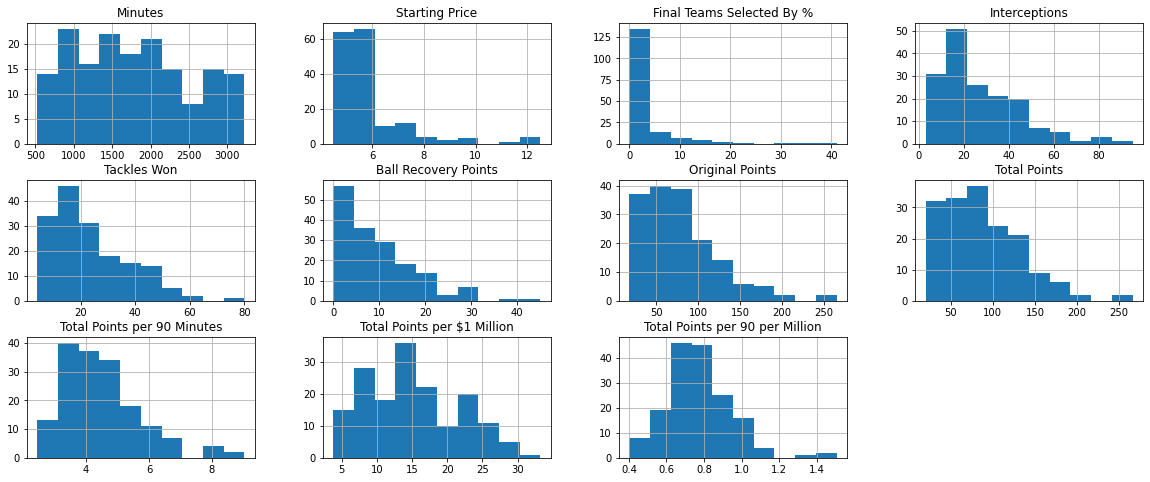

In [14]:
data[data.columns[1:]].hist(bins=10, figsize=(20, 8), layout=(3, 4))
plt.show()

In [15]:
# players whose surnames are 1 word
players1 = {'N\'Golo Kanté' : 'dm', 'Declan Rice' : 'dm', 'Rodri' : 'dm', 'Christian Nørgaard' : 'dm',
            'Rúben Neves' : 'dm', 'Mason Mount' : 'am', 'James Maddison' : 'am', 'Bruno Fernandes' : 'am',
            'Mohamed Salah' : 'w', 'Bukayo Saka' : 'w', 'Raphinha' : 'w', 'Jarrod Bowen' : 'w'}

# players whose surnames are 2 words
players2 = {'Emile Smith Rowe' : 'am', 'Kevin De Bruyne' : 'am'}

pt_color = '#3cdfff'

In [16]:
def label_points(ax, x, y):
    ax.scatter(data[x], data[y], s=15, color=pt_color)

    for player in players1:
      p = data[data['Player'] == player]
      name = player.split()
      # label defensive midfielders red
      if players1[player] == 'dm':
          ax.annotate(name[-1], (p.iloc[0][x], p.iloc[0][y]), fontsize=12, color='red')
      # label attacking midfielders blue
      elif players1[player] == 'am':
          ax.annotate(name[-1], (p.iloc[0][x], p.iloc[0][y]), fontsize=12, color='blue')
      # label wingers black
      else:
          ax.annotate(name[-1], (p.iloc[0][x], p.iloc[0][y]), fontsize=12)

    for player in players2:
        p = data[data['Player'] == player]
        name = player.split()
        # Smith Rowe and De Bruyne are both attacking midfielders, label them blue
        ax.annotate(name[-2] + ' ' + name[-1], (p.iloc[0][x], p.iloc[0][y]), fontsize=12, color='blue')

    # Son's surname comes first in his name (edge case), label him black since he's a winger
    son = data[data['Player'] == 'Son Heung-min']
    ax.annotate('Son', (son.iloc[0][x], son.iloc[0][y]), fontsize=12)

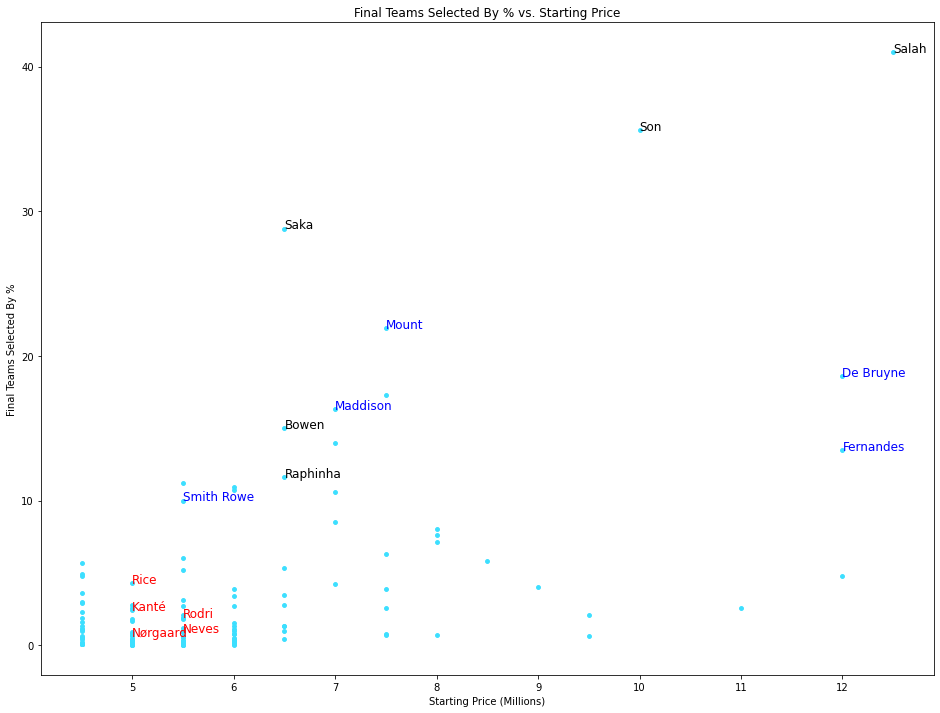

In [17]:
x1 = 'Starting Price'
y1 = 'Final Teams Selected By %'

fig1, ax1 = plt.subplots(figsize=(16,12))
label_points(ax1, x1, y1)

plt.xlabel('Starting Price (Millions)')
plt.ylabel('Final Teams Selected By %')
plt.title('Final Teams Selected By % vs. Starting Price')
plt.show()

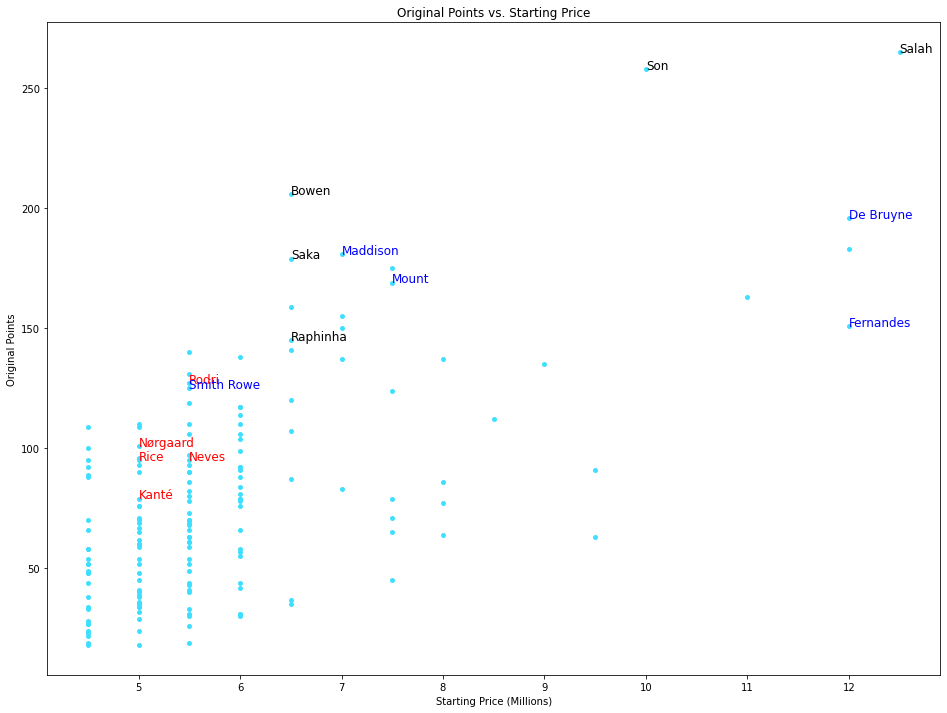

In [18]:
x2 = 'Starting Price'
y2 = 'Original Points'

fig2, ax2 = plt.subplots(figsize=(16,12))
label_points(ax2, x2, y2)

plt.xlabel('Starting Price (Millions)')
plt.ylabel('Original Points')
plt.title('Original Points vs. Starting Price')
plt.show()

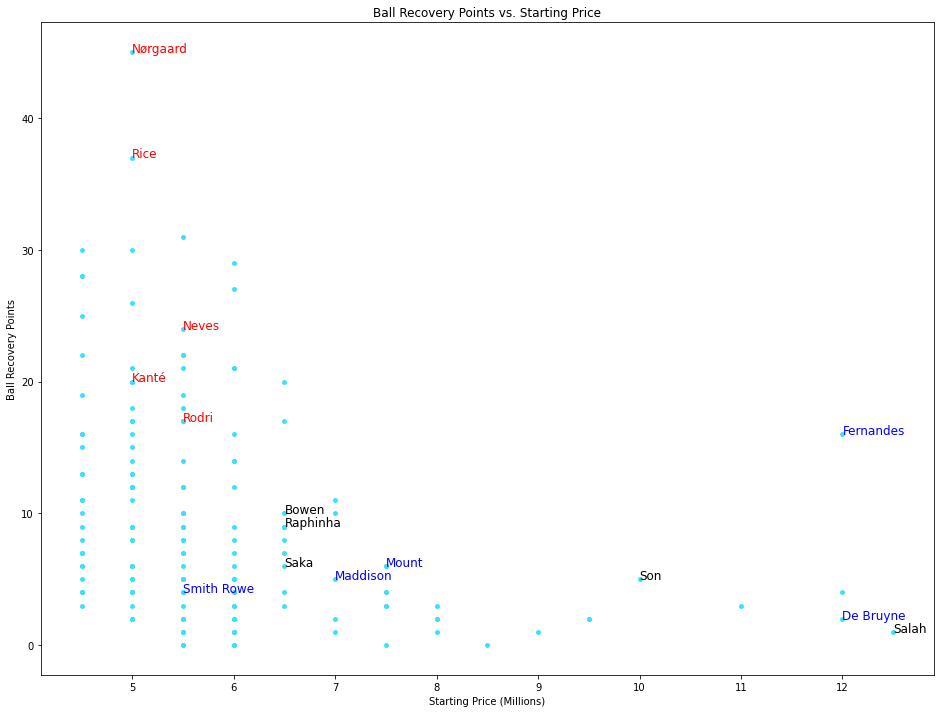

In [19]:
x3 = 'Starting Price'
y3 = 'Ball Recovery Points'

fig3, ax3 = plt.subplots(figsize=(16,12))
label_points(ax3, x3, y3)

plt.xlabel('Starting Price (Millions)')
plt.ylabel('Ball Recovery Points')
plt.title('Ball Recovery Points vs. Starting Price')
plt.show()

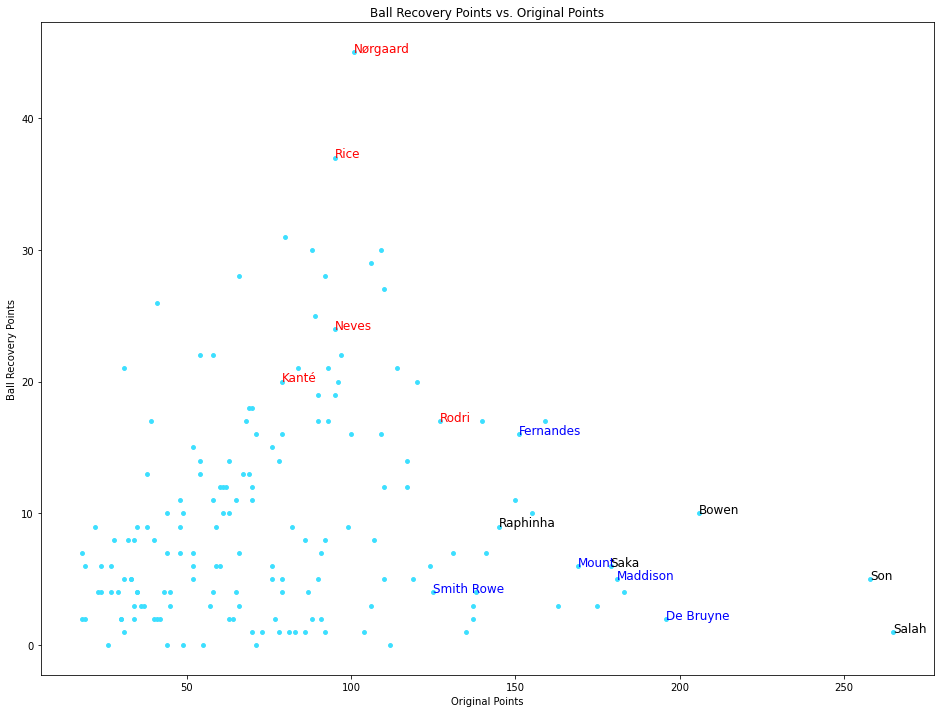

In [20]:
x4 = 'Original Points'
y4 = 'Ball Recovery Points'

fig4, ax4 = plt.subplots(figsize=(16,12))
label_points(ax4, x4, y4)

plt.xlabel('Original Points')
plt.ylabel('Ball Recovery Points')
plt.title('Ball Recovery Points vs. Original Points')
plt.show()

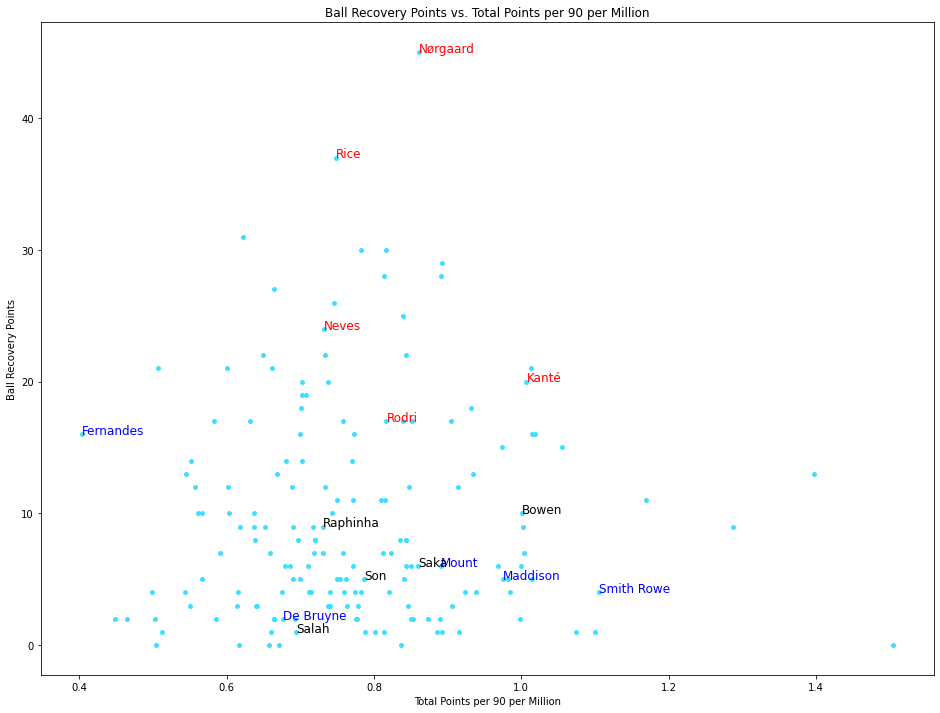

In [21]:
x5 = 'Total Points per 90 per Million'
y5 = 'Ball Recovery Points'

fig5, ax5 = plt.subplots(figsize=(16,12))
label_points(ax5, x5, y5)

plt.xlabel('Total Points per 90 per Million')
plt.ylabel('Ball Recovery Points')
plt.title('Ball Recovery Points vs. Total Points per 90 per Million')
plt.show()

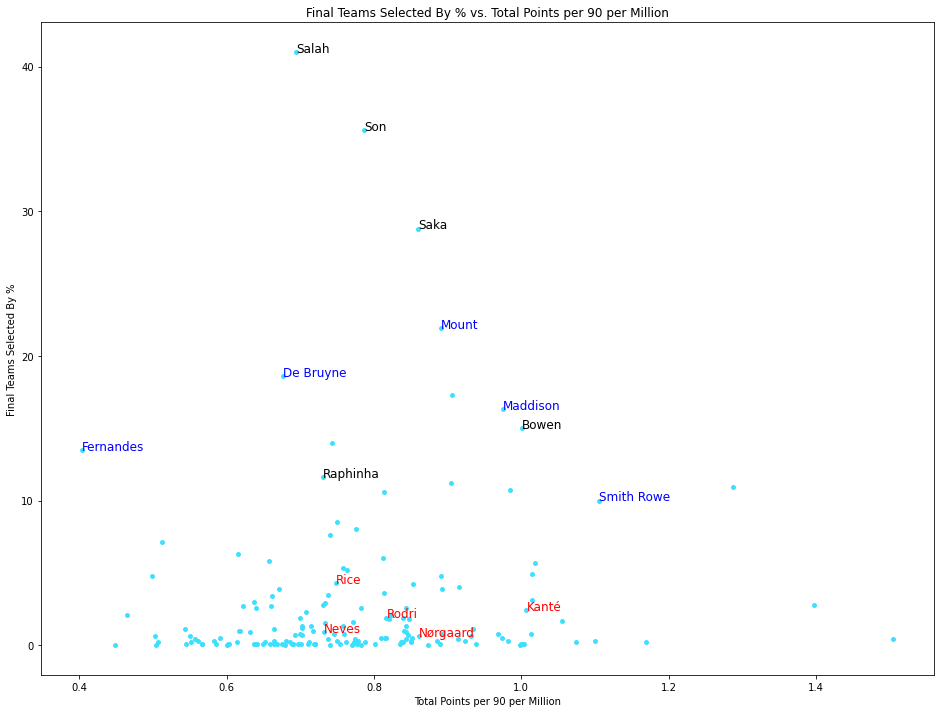

In [22]:
x6 = 'Total Points per 90 per Million'
y6 = 'Final Teams Selected By %'

fig6, ax6 = plt.subplots(figsize=(16,12))
label_points(ax6, x6, y6)

plt.xlabel('Total Points per 90 per Million')
plt.ylabel('Final Teams Selected By %')
plt.title('Final Teams Selected By % vs. Total Points per 90 per Million')
plt.show()

<p>&nbsp;</p>

# Discussion

My analysis reveals that awarding points for ball recoveries is effective in making defensive midfielders more valuable picks in FPL. It is a viable start to help them narrow the large gap in points to attacking midfielders and wingers. However, they largely remain lower-scoring options compared to their more offensive counterparts; Christian Nørgaard and Rodri, the highest scoring defensive midfielders (accounting for ball recoveries), only rank 18th and 19th, respectively, among all FPL midfielders. Nevertheless, this is a considerable improvement on their original ranking for FPL points before adding ball recovery points – 41st for Nørgaard and 23rd for Rodri. Declan Rice and Rúben Neves also move up from 47th and 48th to 30th and 39th, respectively. Due to playing just over 50% of minutes during the season, N'Golo Kanté only places 59th in total points (up from 71st after adding ball recovery points). However, he excels in his total points per 90 per million score, which ranks 13th among all FPL midfielders.

One potential solution to further address the disparity in points between positions is to not award clean sheet points to attacking midfielders and wingers, and increase the clean sheet reward to 2 points for defensive midfielders. The current rule of 1 point for all midfielders means that attacking midfielders and wingers may unfairly benefit from the effort from their team's defenders and defensive midfielders. However, this introduces the problem of how we distinguish between a defensive and attacking midfielder. Certain players fall into a positional gray area or, through their versatility, can serve multiple roles for their team. For instance, it becomes difficult to accurately classify box-to-box and central midfielders such as Ilkay Gündogan and James Ward-Prowse.

Another possibility would be to reclassify wingers as FPL forwards, and change squad selection rules from 5 midfielders and 3 forwards to 4 midfielders and 4 forwards. Of the top 5 highest scoring FPL midfielders, 4 are wingers, of which 3 (Mohamed Salah, Son Heung-min, and Sadio Mané) ranked in the top 5 for most goals scored during the 2021-22 Premier League season. Due to their goalscoring output being comparable with strikers, this reclassification means wingers no longer gain an extra point for a clean sheet. The number of points they earn for each goal also decreases from 5 to 4. This would make them less overpowered and allow users to select more traditional midfielders in their place. However, many common formations in real-life soccer have 5 midfielders, and this rule change would mean users can no longer do so even though they can still make for valid formations. In addition, a valid formation in soccer typically has at most 3 forwards, so presenting users with the option to field 4 forwards would be a significant depart from tradition.

In conclusion, I believe Fantasy Premier League would greatly improve through the introduction of ball recovery points in order to make squad selection less predictable. With there being many template squads with the same core group of high-value players, this modification would allow for greater variance in players in users' teams. However, it is unlikely that these changes get incorporated into the game, considering FPL is known for its simplicity. Applying any of the possible solutions mentioned above would mean wholesale changes to the game, meaning FPL would risk presenting itself as more complicated to casual fans. Ultimately, these limitations of the game are only seen as an issue for the most serious of fans, and Fantasy Premier League is still of great appeal to the wider soccer community.